YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRL=X']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


1 Failed download:
['BRL=X']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Error: Downloaded data is empty! (Likely Rate Limit)
Generating SYNTHETIC data to verify TensorFlow environment...
Generated synthetic data shape: (1793, 1)
Data shape after preprocessing: (1788, 3)
Date range: 2021-01-06 00:00:00 to 2025-11-28 00:00:00
Train data shape: (1272, 1)
Test data shape: (517, 1)
Starting model training...
Epoch 1/5


/opt/homebrew/Caskroom/miniforge/base/envs/lab/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1657 - val_loss: 0.1087
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1657 - val_loss: 0.1087
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0485 - val_loss: 0.0574
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0485 - val_loss: 0.0574
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0360 - val_loss: 0.0509
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0360 - val_loss: 0.0509
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0323 - val_loss: 0.0476
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0323 - val_loss: 0.0476
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0297 - val_loss: 0.0525
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0297 - val_loss: 0.0525
Model training completed successfully!
Model training completed successfully!
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


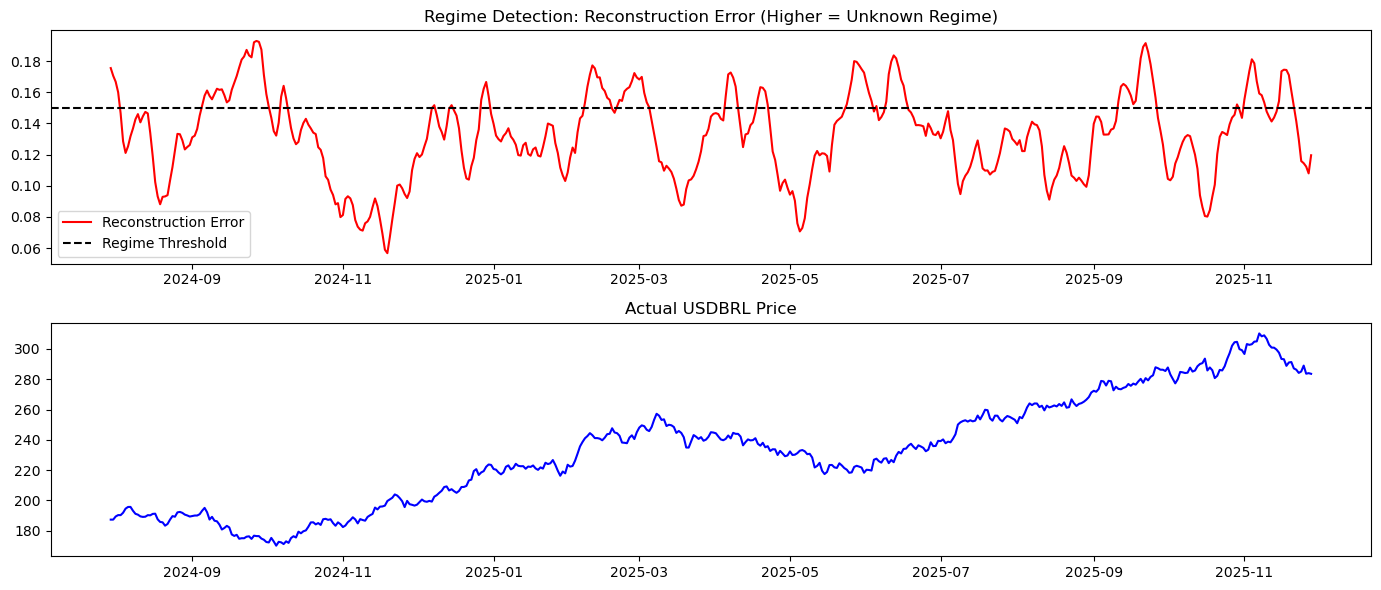

In [ ]:
import os
# Force CPU usage to avoid macOS Metal/GPU crashes
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
try:
    tf.config.set_visible_devices([], 'GPU')
except:
    pass

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

# --- 1. Get Data (USD/BRL) ---
# We download daily data.
ticker = 'BRL=X'
print(f"Downloading data for {ticker}...")
df_raw = yf.download(ticker, start='2010-01-01', end='2025-11-28')

if df_raw.empty:
    print("Error: Downloaded data is empty! (Likely Rate Limit)")
    print("Generating SYNTHETIC data to verify TensorFlow environment...")
    
    # Generate synthetic data
    dates = pd.date_range(start='2010-01-01', end='2025-11-28', freq='D')
    np.random.seed(42)
    # Random walk
    steps = np.random.normal(loc=0.0001, scale=0.01, size=len(dates))
    price_path = 100 * np.exp(np.cumsum(steps))
    
    df_raw = pd.DataFrame(price_path, index=dates, columns=['Close'])
    print(f"Generated synthetic data shape: {df_raw.shape}")
else:
    print(f"Downloaded data shape: {df_raw.shape}")
    print(df_raw.head())

# Handle potential MultiIndex columns from yfinance
if isinstance(df_raw.columns, pd.MultiIndex):
    print("Detected MultiIndex columns, flattening...")
    try:
        data = df_raw['Close']
        if isinstance(data, pd.DataFrame):
             data = data.iloc[:, 0] # Take the first column if it's still a DF
    except KeyError:
        print("KeyError: 'Close' not found in columns")
        print(df_raw.columns)
        data = df_raw.iloc[:, 0] # Fallback
else:
    data = df_raw['Close']

# Feature Engineering: We use Volatility (rolling std dev) as the feature
# because regimes are often defined by volatility shifts, not just price levels.
window_size = 30
df = pd.DataFrame(data)
df.columns = ['Close']  # Ensure column name is set
df['Returns'] = df['Close'].pct_change()
df['Vol'] = df['Returns'].rolling(window=5).std() # 5-day rolling vol
df.dropna(inplace=True)

print(f"Data shape after preprocessing: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")

# Split into Training (Normal Regime) and Testing (Unknown/Potential New Regimes)
train_end = '2020-12-31'
train_data = df.loc[:train_end, ['Vol']]
test_data = df.loc[train_end:, ['Vol']]

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

if train_data.empty:
    print("Error: Train data is empty! Check the date slicing.")
    # Check index type
    print(f"Index type: {type(df.index)}")
    if len(df.index) > 0:
        print(f"Index example: {df.index[0]}")
else:
    # Scale Data (Crucial for Neural Networks)
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    train_scaled = scaler.transform(train_data)
    test_scaled = scaler.transform(test_data)

    # --- 2. Create Sequences (LSTM requires 3D input: [Samples, Timesteps, Features]) ---
    def create_sequences(data, steps=30):
       sequences = []
       for i in range(len(data) - steps):
           sequences.append(data[i:(i + steps)])
       return np.array(sequences)

    TIME_STEPS = 30
    X_train = create_sequences(train_scaled, TIME_STEPS)
    X_test = create_sequences(test_scaled, TIME_STEPS)

    # --- 3. Build the LSTM Autoencoder ---
    model = Sequential([
       # Encoder: Compresses the 30-day sequence into a small vector
       LSTM(16, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),

       # The "Latent Space" (Compressed Representation)
       RepeatVector(X_train.shape[1]),

       # Decoder: Unpacks the vector back into the 30-day sequence
       LSTM(16, activation='relu', return_sequences=True),
       TimeDistributed(Dense(X_train.shape[2]))
    ])

    model.compile(optimizer='adam', loss='mse')
    print("Starting model training...")
    model.fit(X_train, X_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)
    print("Model training completed successfully!")

    # --- 4. Detect Regimes (Calculate Reconstruction Error) ---
    # We ask the model to reconstruct the Test data (Jul 2024+)
    X_test_pred = model.predict(X_test)

    # Calculate Mean Absolute Error (MAE) for each day
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

    # Create a DataFrame for plotting
    test_score_df = pd.DataFrame(index=test_data[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = 0.15  # Set a manual threshold for visual clarity
    test_score_df['Close'] = df.loc[test_score_df.index]['Close']

    # --- 5. Visualization ---
    plt.figure(figsize=(14, 6))

    # Plot 1: The Reconstruction Error (The "Regime Signal")
    plt.subplot(2, 1, 1)
    plt.plot(test_score_df.index, test_score_df['loss'], label='Reconstruction Error', color='red')
    plt.axhline(y=0.15, color='black', linestyle='--', label='Regime Threshold')
    plt.title('Regime Detection: Reconstruction Error (Higher = Unknown Regime)')
    plt.legend()

    # Plot 2: The Actual Price (USDBRL)
    plt.subplot(2, 1, 2)
    plt.plot(test_score_df.index, test_score_df['Close'], label='USDBRL Price', color='blue')
    plt.title('Actual USDBRL Price')

    plt.tight_layout()
    plt.show()